In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

from gtsrb import GTSRB

%matplotlib inline

In [2]:
metafile = 'F:\\traffic-images\\classids.csv'
train_dir = 'F:\\traffic-images\\Final_Training\\Images'
test_dir = 'F:\\traffic-images\\Final_Test\\Images'     # no labels, useless

In [3]:
rawdata = GTSRB(train_dir, train=True, meta=metafile)
trainset, valset = random_split(rawdata, [len(rawdata)-9000, 9000])
print('trainning size: %d, val size: %d' % (len(trainset), len(valset)))

trainning size: 30209, val size: 9000


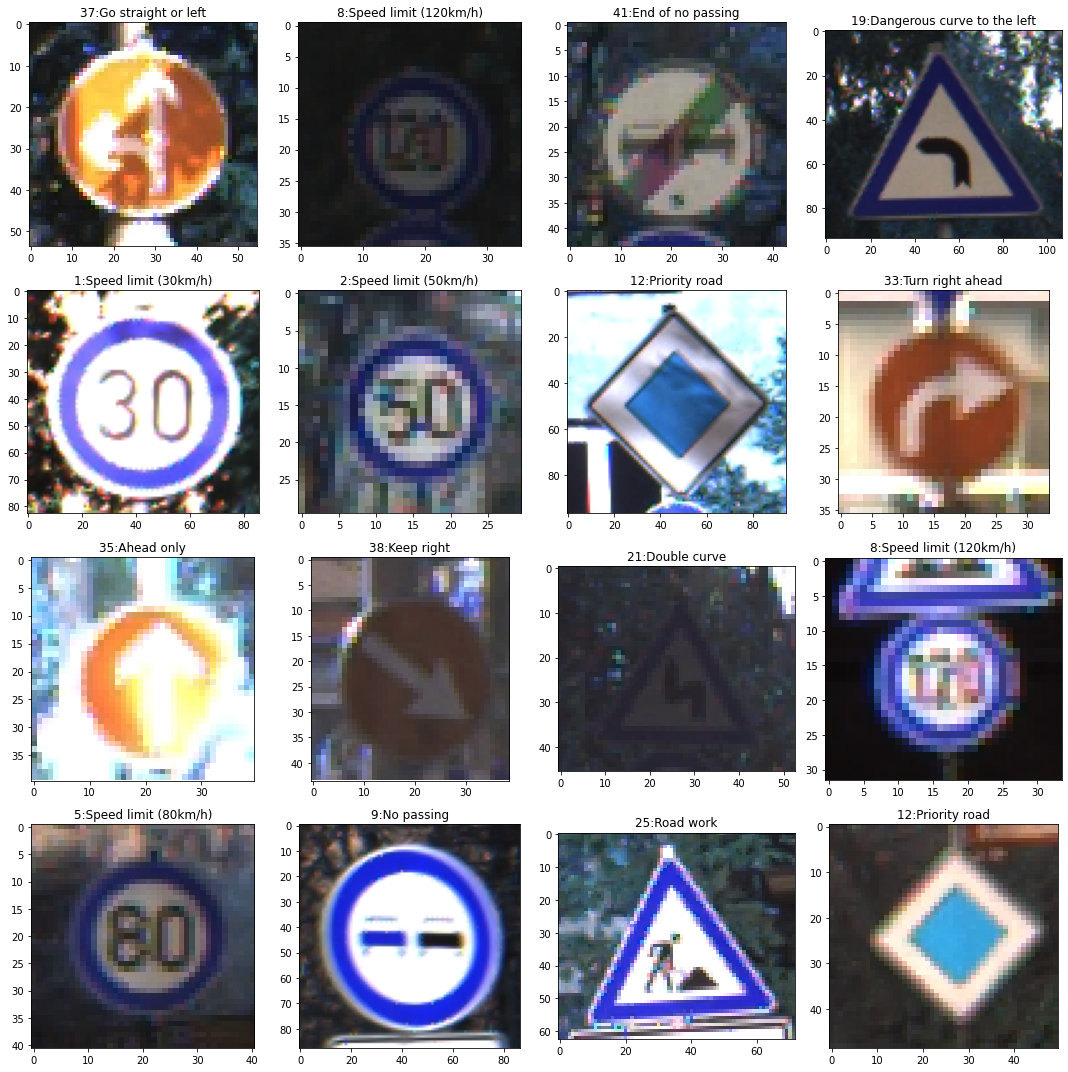

In [10]:
_, axis = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axis.flat):
    img, label = trainset[i]
    ax.imshow(img)
    ax.set_title('%d:%s' % (label, rawdata.id2name['%05d' % label]))

plt.tight_layout()
plt.show()